In [7]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py
import healpy as hp

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle 
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import gala.coordinates as gc
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()
import yaml

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [8]:
def orbpole(xs,vs):
    uu = np.cross(xs, vs)
    uumag = np.linalg.norm(uu)
    u = uu.T/uumag
    b = np.arcsin(u[2])
    sinl = u[1]/np.cos(b)
    cosl = u[0]/np.cos(b)
    ll = np.arctan2(sinl, cosl)
    gl = np.degrees(ll)
    gb = np.degrees(b)
    return gl, gb    

In [24]:
def mollewide_poles(path_data, pots, pot_labels, plotname, cbar, savefig=False):

    lmc_xs, lmc_vs = Model.expansion_centres(0.)[6:9], Model.expansion_centre_velocities(0.)[6:9]
    lmc_lpole, lmc_bpole = orbpole(np.array(lmc_xs), np.array(lmc_vs))

    pltidx = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1), (4,0), (4,1)]

    fig, ax = plt.subplots(4, 2, subplot_kw={'projection': 'mollweide'}, figsize=(14, 16))

    plt.subplots_adjust(hspace=-0.1, wspace=0.1)

    for j in range(len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:
            
            t_idx = -1
            # l_gc = np.array(file['l_gc'])
            # l_gc_wrap = Angle(l_gc * u.deg)
            # b_gc = np.array(file['b_gc'])
            ds = np.array(file['ds'])
            rlmc = np.array(file['lmc_sep'])
            loc_veldis = np.array(file['loc_veldis'])

            l_pole = np.array(file['pole_l'])[:,t_idx]
            l_pole_std = np.nanstd(l_pole, axis=1)
            b_pole = np.array(file['pole_b'])[:,t_idx]
            b_pole_std = np.nanstd(b_pole, axis=1)
            # vlos = np.array(file['vlos'])
            sigmavlos = np.array(file['sigmavlos'])

            lons = np.array(file['lons'])

        # if j ==0:
        #     mask = (loc_veldis < 30)

        plt.sca(ax[pltidx[j]])
        plt.grid(alpha=.25)
        rng = np.random.default_rng(seed=1)
        Nstreams, Nparticles = 25, 1000
        Nsample = (Nstreams, Nparticles)

        l_poles_sample = rng.choice(l_pole, axis=0, size=Nsample[0])
        b_poles_sample = rng.choice(b_pole, axis=0, size=Nsample[0])
        lons_sample = rng.choice(lons, axis=0, size=Nsample[0])
        # ds_sample = rng.choice(ds[mask], axis=0, size=Nsample[0])
        rlmc_sample = rng.choice(rlmc, axis=0, size=Nsample[0])

        l_poles_sample_red = rng.choice(l_poles_sample, axis=1, size=Nsample[1])
        b_poles_sample_red = rng.choice(b_poles_sample, axis=1, size=Nsample[1])
        lons_sample_red = rng.choice(lons_sample, axis=1, size=Nsample[1])
        # ds_sample_red = rng.choice(ds_sample, axis=1, size=Nsample[1])
        rlmc_sample_red = rng.choice(rlmc_sample, axis=1, size=Nsample[1])

        sample_ls = (l_poles_sample_red*u.deg + 180*u.deg)
        wrapped_sample_ls = np.where(sample_ls.value>=180, sample_ls.value - 360, sample_ls.value)

   
        if cbar=='distance':
        
            sc=plt.scatter(((wrapped_sample_ls)*u.deg.to(u.rad) ), ((b_poles_sample_red*u.deg).to(u.rad)),s=3,
              c=rlmc_sample_red, vmin=0, vmax=40, cmap='plasma_r', rasterized=True)

            plt.scatter((lmc_lpole*u.deg - 180*u.deg).to(u.rad), (lmc_bpole*u.deg ).to(u.rad), s=100,
                            edgecolors='k', facecolor='orange',marker='*', label='LMC', rasterized=True)
            
            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$\mathbf{r}_\mathrm{LMC,\,closest\,sep}\,[\mathrm{kpc}]$')
            cb.ax.tick_params(labelsize=12)
            
        if cbar=='lon_frac':
            
            sc=plt.scatter((wrapped_sample_ls)*u.deg.to(u.rad), (b_poles_sample_red*u.deg).to(u.rad), 
               c=lons_sample_red/180, cmap='coolwarm',s=3,rasterized=True,
              norm=SymLogNorm(linthresh=0.01, linscale=0.00001, vmin=-1, vmax=1))
        
            plt.scatter((lmc_lpole*u.deg - 180*u.deg).to(u.rad), (lmc_bpole*u.deg ).to(u.rad), s=100,
                        edgecolors='k', facecolor='orange',marker='*', label='LMC', rasterized=True)

            plt.scatter(((wrapped_sample_ls)*u.deg.to(u.rad) )[:,0], ((b_poles_sample_red*u.deg).to(u.rad))[:,0],s=10,
                    edgecolors='k', facecolor='limegreen',marker='o',label='Prog.', rasterized=True)

            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$f_{\mathrm{particle}}(\psi_1)$')
            cb.ax.tick_params(labelsize=12)
            cb.set_ticks([ -0.5, -0.1, 0, 0.1, 0.5 ]) 
            cb.set_ticklabels([ '-0.5','-0.1', '0', '0.1','0.5']) 

        ax[pltidx[j]].set_xticks([-np.pi,-3*np.pi/4,-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4,np.pi], 
                  labels=[r'$0\,^{\circ}$','','','','','', '','',r'$360\,^{\circ}$',])
        ax[pltidx[j]].set_yticks([-np.pi/2, -np.pi/4, -np.pi/8, 0, np.pi/8,np.pi/4, np.pi/2],
                 labels=[r'$-90\,^{\circ}$', '', '','','','', r'$90\,^{\circ}$',])

        plt.title(labels[j], loc='left', fontsize=10)
        if j ==0:
            plt.legend(frameon=False, fontsize=7, loc='upper right')
            
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/{}'.format(plotname + '_' + cbar))
    # plt.close()

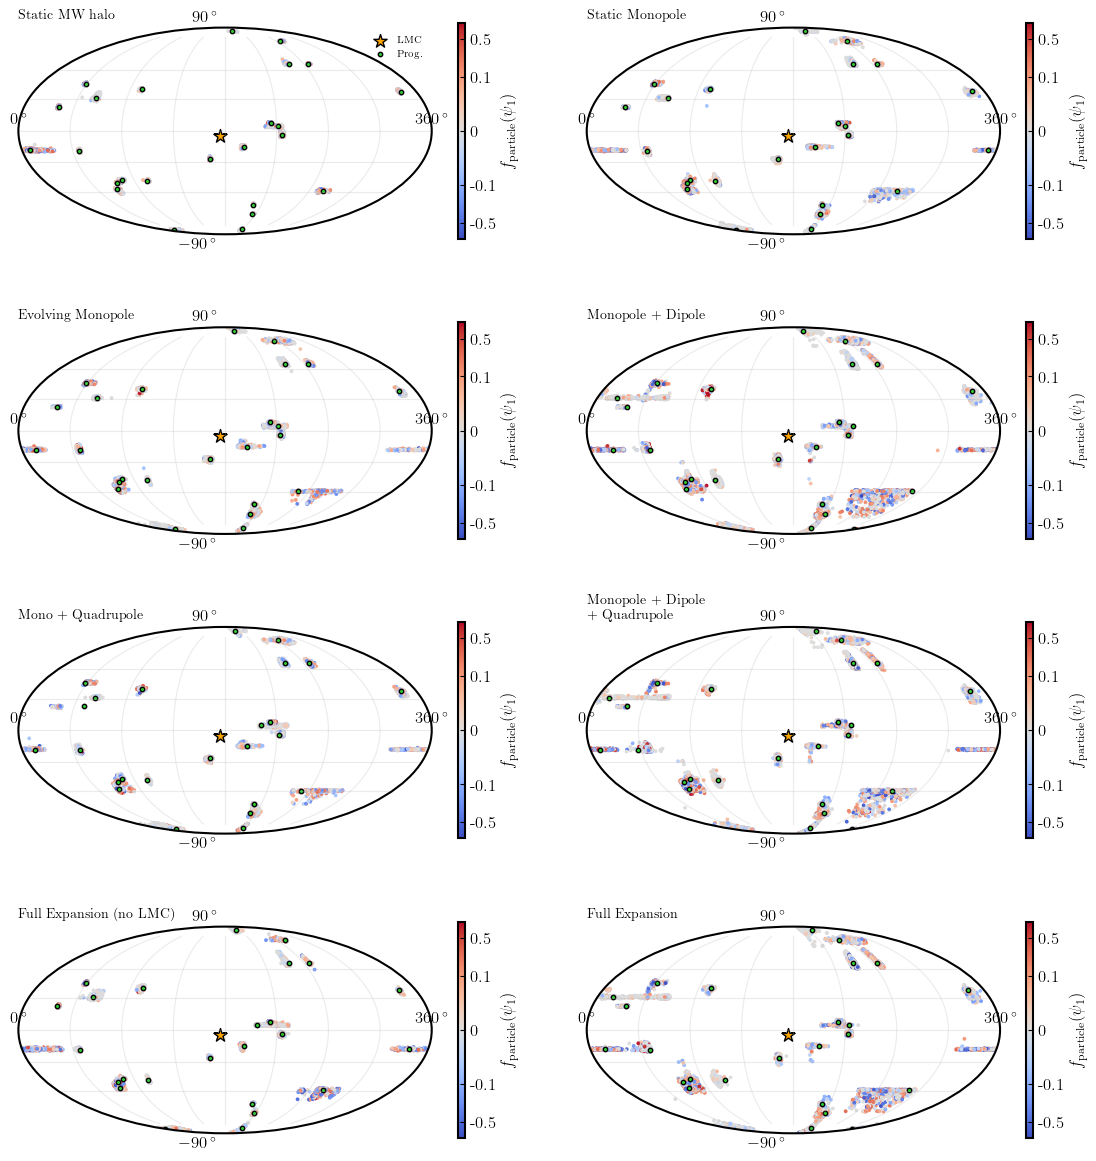

In [25]:
# path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-5kpcrpmin/'

path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'

potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                        'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5',])

labels = list(['Static MW halo','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
               'Monopole + Dipole \n + Quadrupole',  'Full Expansion (no LMC)', 'Full Expansion',])

mollewide_poles(path, potentials, labels, 'mollweide_poles', 'lon_frac', True)

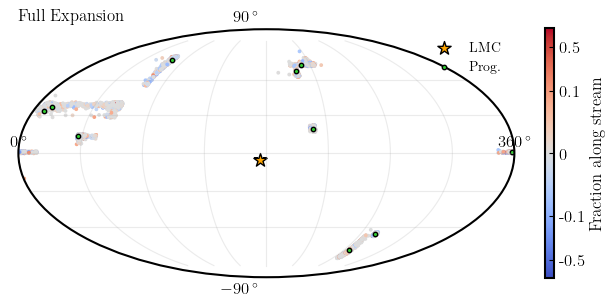

In [5]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'

potential = 'Full-MWhalo-MWdisc-LMC.hdf5'
label =  'Full Expansion'

lmc_xs, lmc_vs = Model.expansion_centres(0.)[6:9], Model.expansion_centre_velocities(0.)[6:9]
lmc_lpole, lmc_bpole = orbpole(np.array(lmc_xs), np.array(lmc_vs))

fig, ax = plt.subplots(1,1, subplot_kw={'projection': 'mollweide'}, figsize=(8, 5))

    
with h5py.File(path + potential,'r') as file:
    # print(file.keys())
    
    t_idx = -1

    l_gc = np.array(file['l_gc'])
    l_gc_wrap = Angle(l_gc * u.deg)
    b_gc = np.array(file['b_gc'])
    ds = np.array(file['ds'])
    loc_veldis = np.array(file['loc_veldis'])

    l_pole = np.array(file['pole_l'])[:,t_idx]
    l_pole_std = np.nanstd(l_pole, axis=1)
    b_pole = np.array(file['pole_b'])[:,t_idx]
    b_pole_std = np.nanstd(b_pole, axis=1)
    vlos = np.array(file['vlos'])
    sigmavlos = np.array(file['sigmavlos'])
    
    lons = np.array(file['lons'])
    
rng = np.random.default_rng(seed=1)
Nsample = (10, 2000)

l_poles_sample = rng.choice(l_pole[loc_veldis < 20], axis=0, size=Nsample[0])
b_poles_sample = rng.choice(b_pole[loc_veldis < 20], axis=0, size=Nsample[0])
lons_sample = rng.choice(lons[loc_veldis < 20], axis=0, size=Nsample[0])

l_poles_sample_red = rng.choice(l_poles_sample, axis=1, size=Nsample[1])
b_poles_sample_red = rng.choice(b_poles_sample, axis=1, size=Nsample[1])
lons_sample_red = rng.choice(lons_sample, axis=1, size=Nsample[1])


plt.sca(ax)
plt.grid(alpha=.25)

sample_ls = (l_poles_sample_red*u.deg + 180*u.deg)
wrapped_sample_ls = np.where(sample_ls.value>=180, sample_ls.value - 360, sample_ls.value)

sc=plt.scatter((wrapped_sample_ls)*u.deg.to(u.rad), (b_poles_sample_red*u.deg).to(u.rad), 
               c=lons_sample_red/180, cmap='coolwarm',s=3,rasterized=True,
              norm=SymLogNorm(linthresh=0.01, linscale=0.00001, vmin=-1, vmax=1))

plt.scatter((lmc_lpole*u.deg - 180*u.deg).to(u.rad), (lmc_bpole*u.deg ).to(u.rad), s=100,
                edgecolors='k', facecolor='orange',marker='*', label='LMC', rasterized=True)

plt.scatter(((wrapped_sample_ls)*u.deg.to(u.rad) )[:,0], ((b_poles_sample_red*u.deg).to(u.rad))[:,0],s=10,
                edgecolors='k', facecolor='limegreen',marker='o', label='Prog.', rasterized=True)

cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
cb.set_label(r'Fraction along stream')
cb.ax.tick_params(labelsize=12)
cb.set_ticks([ -0.5, -0.1, 0, 0.1, 0.5 ]) 
cb.set_ticklabels([ '-0.5','-0.1', '0', '0.1','0.5']) 

ax.set_xticks([-np.pi,-3*np.pi/4,-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4,np.pi], 
              labels=[r'$0\,^{\circ}$','','','','','', '','',r'$360\,^{\circ}$',])
ax.set_yticks([-np.pi/2, -np.pi/4, -np.pi/8, 0, np.pi/8,np.pi/4, np.pi/2],
             labels=[r'$-90\,^{\circ}$', '', '','','','', r'$90\,^{\circ}$',])

plt.title(label, loc='left')
plt.legend(frameon=False, fontsize=10)

Spread of orbital poles

In [3]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'

potential = 'Full-MWhalo-MWdisc-LMC.hdf5'
label = 'Full Expansion'

with h5py.File(path + potential,'r') as file:
    
    pericenters = np.array(file['pericenter'])
    lmc_closest = np.nanmin(np.array(file['lmc_sep']),axis=1)
    l_pole = np.array(file['pole_l'])
    b_pole = np.array(file['pole_b'])
    loc_veldis = np.array(file['loc_veldis'])

In [36]:
rng = np.random.default_rng(seed=1)
Nsample = (1, 5000)

mask = (loc_veldis < 10)

l_poles_sample = rng.choice(l_pole[mask], axis=0, size=Nsample[0])
b_poles_sample = rng.choice(b_pole[mask], axis=0, size=Nsample[0])

l_poles_sample_red = rng.choice(l_poles_sample, axis=2, size=Nsample[1])
b_poles_sample_red = rng.choice(b_poles_sample, axis=2, size=Nsample[1])

In [37]:
l_pole_std = np.nanstd(l_poles_sample_red, axis=2)
b_pole_std = np.nanstd(b_poles_sample_red, axis=2)

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [38]:
tot_pole_std = (l_pole_std**2 + b_pole_std**2)**0.5

In [39]:
ts_snaps = np.linspace(-5, 0, 21)

(0.0, 4.505887607502481)

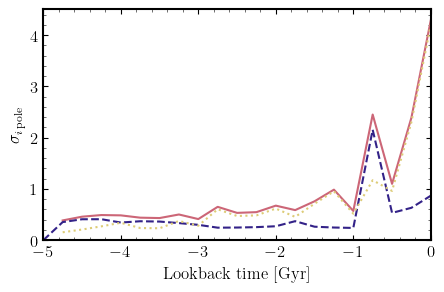

In [40]:
fig, ax = plt.subplots(1,1, figsize=(5, 3))

plt.plot(ts_snaps, tot_pole_std.T , label = r'$\sigma_{\mathrm{total},\,\mathrm{pole}}$')
plt.plot(ts_snaps, l_pole_std.T , ls='dashed', label = r'$\sigma_{l,\,\mathrm{pole}}$')
plt.plot(ts_snaps, b_pole_std.T , ls='dotted', label = r'$\sigma_{b,\,\mathrm{pole}}$')

plt.xlabel('Lookback time [Gyr]')
plt.ylabel(r'$\sigma_{i\,\mathrm{pole}}$')
plt.xlim(-5,0)
plt.ylim(0,)

Dispersions vs pericenter and closest lmc approach

In [5]:
def pole_dispersions(path_data, pot, label, plotname, xaxis, savefig=False):

    lmc_xs, lmc_vs = Model.expansion_centres(0.)[6:9], Model.expansion_centre_velocities(0.)[6:9]
    lmc_lpole, lmc_bpole = orbpole(np.array(lmc_xs), np.array(lmc_vs))

    fig, ax = plt.subplots(1,1, figsize=(10, 5))

    # plt.subplots_adjust(hspace=-0.1, wspace=0.1)

    with h5py.File(path + pot,'r') as file:
        pericenters = np.array(file['pericenter'])
        lmc_closest = np.nanmin(np.array(file['lmc_sep']),axis=1)
        l_pole = np.array(file['pole_l'])
        b_pole = np.array(file['pole_b'])
        loc_veldis = np.array(file['loc_veldis'])

    rng = np.random.default_rng(seed=1)
    Nstreams, Nparticles = 10, 2000
    Nsample = (Nstreams, Nparticles)

    mask = (loc_veldis < 10)

    l_poles_sample = rng.choice(l_pole[mask], axis=0, size=Nsample[0])
    b_poles_sample = rng.choice(b_pole[mask], axis=0, size=Nsample[0])
    peri_sample = rng.choice(pericenters[mask], axis=0, size=Nsample[0])
    rlmc_sample = rng.choice(lmc_closest[mask], axis=0, size=Nsample[0])
    
    print(peri_sample.shape, l_poles_sample_red.shape)

    l_poles_sample_red = rng.choice(l_poles_sample, axis=2, size=Nsample[1])
    b_poles_sample_red = rng.choice(b_poles_sample, axis=2, size=Nsample[1])
    rlmc_sample_red = rng.choice(rlmc_sample, axis=2, size=Nsample[1])

    tot_pole_std_sample_red = (l_pole_std_sample_red**2 + b_pole_std_sample_red**2)**0.5

    plt.sca(ax)

    if cbar=='pericenters':

        plt.scatter(peri_sample, l_poles_sample_red, label=r'$\sigma_{l,\,\mathrm{pole}}$', rasterized=True)
        plt.scatter(peri_sample, b_poles_sample_red, label=r'$\sigma_{b,\,\mathrm{pole}}$', rasterized=True)
        plt.scatter(peri_sample, tot_pole_std_sample_red, label=r'$\sigma_{\mathrm{total},\,\mathrm{pole}}$', rasterized=True)

    if cbar=='lmc_sep':

        plt.scatter(rlmc_sample_red, l_poles_sample_red, label=r'$\sigma_{l,\,\mathrm{pole}}$', rasterized=True)
        plt.scatter(rlmc_sample_red, b_poles_sample_red, label=r'$\sigma_{b,\,\mathrm{pole}}$', rasterized=True) 
        plt.scatter(rlmc_sample_red, tot_pole_std_sample_red, label=r'$\sigma_{\mathrm{total},\,\mathrm{pole}}$', rasterized=True)

    if j ==0:
        plt.legend(frameon=False, fontsize=7, loc='upper right')
            
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' +cbar))
    # plt.close()

In [ ]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'

pole_dispersions(path, 'Full-MWhalo-MWdisc-LMC.hdf5', 'Full Expansion', 'pole_dispersions', 'pericenters', False)